# import libraries

In [1]:
from constants import *
import camera_lib
import matplotlib.pyplot as plt
from ultralytics import YOLO
import clip
import torch
import cv2
from PIL import Image
import math
from bonus.gpt import get_destinaiton
import RobotArm

# test camera

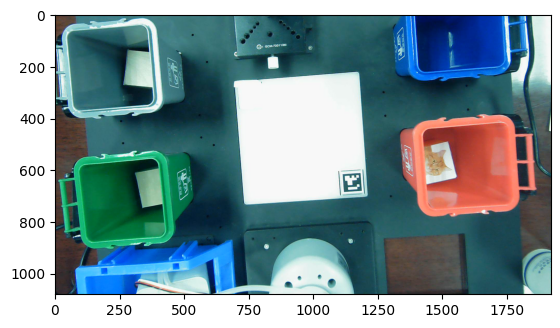

In [2]:
cam = camera_lib.Camera(0)
img = cam.capture1920x1080()
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

# test cut algorithm

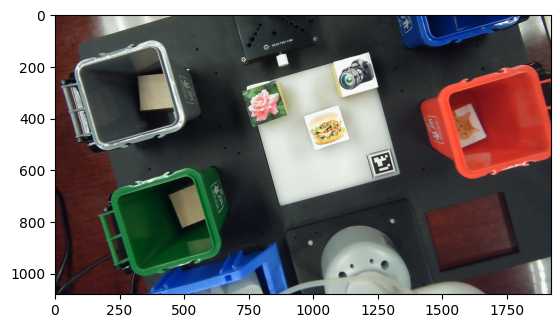

In [3]:
img = cam.capture1920x1080()
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

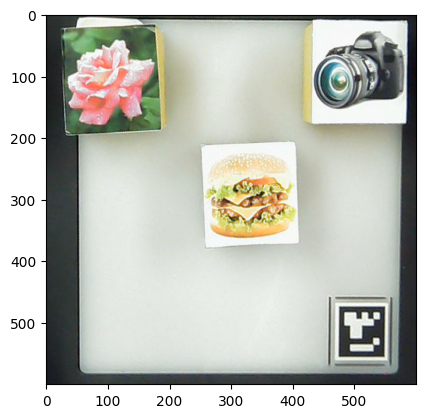

In [4]:
# img = cam.capture1920x1080()
img_cut = camera_lib.cut_image(img)
plt.figure()
plt.imshow(img_cut)
plt.show()

# prepare pretrained models

## CLIP

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## YOLO

In [6]:
yolo = YOLO("../yolov8m-oiv7.pt")

# test image segment


0: 640x640 2 Baked goodss, 2 Cameras, 2 Flowers, 2 Foods, 3 Picture frames, 3 Roses, 1 Table, 478.2ms
Speed: 6.8ms preprocess, 478.2ms inference, 7.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict17
tensor([ 82., 427.,  82., 199., 199., 386., 386.,  17., 386., 195.,  17., 427., 427., 195., 514.]) tensor([0.6635, 0.4687, 0.2092, 0.1393, 0.1106, 0.1085, 0.1056, 0.0964, 0.0197, 0.0175, 0.0170, 0.0155, 0.0126, 0.0113, 0.0108]) tensor([[507.9793,  90.3780, 149.8306, 129.2490],
        [105.5885, 111.3754, 143.5002, 143.0439],
        [501.4237,  92.7152, 174.1783, 174.2772],
        [332.0249, 293.4660, 147.6271, 141.1764],
        [334.2540, 311.4594, 142.4213, 102.4261],
        [107.6408, 103.8746, 174.9583, 192.4436],
        [330.6183, 293.2483, 159.5950, 174.2968],
        [334.9313, 312.6934, 141.8951, 100.7826],
        [302.1990, 299.5497, 595.6020, 592.8967],
        [146.0881, 121.9925,  59.6324, 100.1035],
        [329.4751, 291.1356, 158

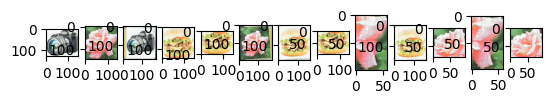

In [7]:
cutted = Image.fromarray(img_cut)
results = yolo(cutted,save=True, conf=0.01)

cutted_np = np.array(cutted)
tmp_box = []
for r in results:
    box=r.boxes
    cls=box.cls
    conf=box.conf
    xywh=box.xywh
    print(cls,conf,xywh)
    # 边界框坐标

    img_list=[]
    for i in range(0,len(box)): 
        [x, y, w, h] = xywh[i]  # 替换为实际的边界框坐标
        x=math.floor(x)
        y=math.floor(y)
        w=math.floor(w)
        h=math.floor(h)
        # 创建分割图像的掩膜
        if y > 400:
            continue
        if w > 200 or h > 200:
            continue
        if w < 50 or h < 50:
            continue
        tmp_box.append(xywh[i])
        # 分割部分的图像
        segmented_image = Image.fromarray(cutted_np[y-h//2:y+h//2, x-w//2:x+w//2])
        img_list.append(segmented_image)

original_images = img_list
plt.figure()
for id, img in enumerate(original_images):
    plt.subplot(1, len(original_images), id+1)
    plt.imshow(img)
plt.show()

# get similarities via CLIP

In [8]:
images = []

query = f"{input()}"

texts = [].append(query)

for img in original_images:
    images.append(preprocess(img))

image_input = torch.tensor(np.stack(images))
text_token = clip.tokenize(query)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_token).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

[[    0.20823     0.19902     0.21119     0.25712     0.25543     0.21684     0.26087     0.25104     0.20952     0.25917     0.20846     0.21413     0.21211]]


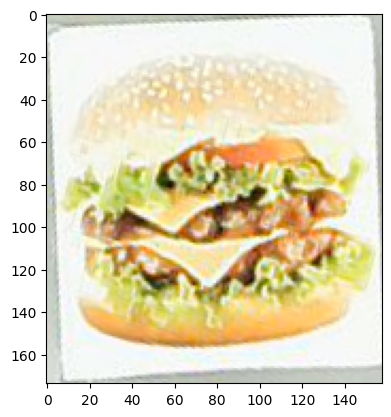

tensor([330.6183, 293.2483])


In [9]:
print(similarity)
best = np.argmax(similarity)
plt.figure()
plt.imshow(original_images[best])
plt.show()
xy = tmp_box[best]
xy = xy[:2]
print(xy)

# Robot Arm

In [10]:
need_bonus = False

In [78]:
query = "select the blackest object to the red bin"

In [11]:
if need_bonus:
    prompt = f"If left front bin is gray, left back bin is green, right front bin is blue, right back bin is red, {query}."
    dest = get_destinaiton(prompt)
    print(dest)
    if dest == "left front":
        binn = 0
    elif dest == "left back":
        binn = 1
    elif dest == "right front":
        binn = 2
    else:
        binn = 3
    RobotArm.move(xy[0], xy[1], binn)
else:
    RobotArm.move(xy[0], xy[1], 2)

# Additional abilities

In [13]:
def select_single(object_prompt, dest_str):
    img = cam.capture1920x1080()
    img_cut = camera_lib.cut_image(img)

    cutted = Image.fromarray(img_cut)
    results = yolo(cutted,save=True, conf=0.01)

    cutted_np = np.array(cutted)
    tmp_box = []
    for r in results:
        box=r.boxes
        cls=box.cls
        conf=box.conf
        xywh=box.xywh
        print(cls,conf,xywh)
        # 边界框坐标

        img_list=[]
        for i in range(0,len(box)): 
            [x, y, w, h] = xywh[i]  # 替换为实际的边界框坐标
            x=math.floor(x)
            y=math.floor(y)
            w=math.floor(w)
            h=math.floor(h)
            # 创建分割图像的掩膜
            if y > 400:
                continue
            if w > 200 or h > 200:
                continue
            if w < 50 or h < 50:
                continue
            tmp_box.append(xywh[i])
            # 分割部分的图像
            segmented_image = Image.fromarray(cutted_np[y-h//2:y+h//2, x-w//2:x+w//2])
            img_list.append(segmented_image)

    original_images = img_list

    images = []

    query = object_prompt

    for img in original_images:
        images.append(preprocess(img))

    image_input = torch.tensor(np.stack(images))
    text_token = clip.tokenize(query)
    with torch.no_grad():
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_token).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

    # print(similarity)
    best = np.argmax(similarity)
    # plt.figure()
    # plt.imshow(original_images[best])
    # plt.show()
    xy = tmp_box[best]
    xy = xy[:2]
    # print(xy)

    if dest_str == "left front":
        binn = 0
    elif dest_str == "left back":
        binn = 1
    elif dest_str == "right front":
        binn = 2
    else:
        binn = 3
    RobotArm.move(xy[0], xy[1], binn)

In [14]:
import bonus.gpt4 as gpt2

In [17]:
queries = input()
obs = gpt2.get_destinaiton(f"If left front bin is gray, left back bin is green, right front bin is blue, right back bin is red, {queries}")
print(obs)
num = len(obs) // 2
for i in range(num):
    select_single(obs[2*i], obs[2*i+1])


                follow these examples: 
                Q: If left front bin is red, left back bin is gray, right front bin is green, right back bin is blue, put all fruits from the table into the red bin.
                A: fruits,left front
                Q: If left front bin is black, left back bin is gray, right front bin is purple, right back bin is yellow, select two balls from the scene and drop it to the right back.
                A: ball,right back,ball,right back
                Q: If left front bin is gray, left back bin is green, right front bin is blue, right back bin is red, select food and water from the desk to the green bin.
                A: food,left back,water,left back
                Q: If left front bin is gray, left back bin is green, right front bin is blue, right back bin is red, select the black object.
                A: black object,default
                Q: If left front bin is gray, left back bin is green, right front bin is blue, right back bin is r